In [13]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
#plt.rcParams['figure.dpi'] = 150

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Building information footprint when the number of RNAPs/repressors exists on a distribution

In [6]:
def simrep_pbound_with_noise(p_seq, r_seq, n_NS,
                             p_emat, r_emat, ep_wt, er_wt,
                             mean_p, mean_r, alpha):

    n_p_exponent = np.random.normal(np.log(mean_p), alpha * np.log(mean_p), 1)[0]
    n_r_exponent = np.random.normal(np.log(mean_r), alpha * np.log(mean_r), 1)[0]

    n_p_new = np.exp(n_p_exponent)
    n_r_new = np.exp(n_r_exponent)
    
    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_r = tregs.simulate.get_weight(r_seq, r_emat, e_wt=er_wt)

    z = np.zeros(3)
    z[0] = 1
    z[1] = n_p_new / n_NS * w_p
    z[2] = n_r_new / n_NS * w_r

    return z[1] / np.sum(z)

In [21]:
n_NS = len(genome)
ep_wt = -5
er_wt = -15
mean_p = 5000
mean_r = 10

alpha = 0.1
dist_p = []
dist_r = []
for i in range(5000):
  n_p_exponent = np.random.normal(np.log(mean_p), alpha * np.log(mean_p), 1)[0]
  n_r_exponent = np.random.normal(np.log(mean_r), alpha * np.log(mean_r), 1)[0]

  n_p_new = int(np.exp(n_p_exponent))
  n_r_new = int(np.exp(n_r_exponent))
  dist_p.append(n_p_new)
  dist_r.append(n_r_new)

In [19]:
alpha = 0.5
dist_p_high = []
dist_r_high = []
for i in range(5000):
  n_p_exponent = np.random.normal(np.log(mean_p), alpha * np.log(mean_p), 1)[0]
  n_r_exponent = np.random.normal(np.log(mean_r), alpha * np.log(mean_r), 1)[0]

  n_p_new = int(np.exp(n_p_exponent))
  n_r_new = int(np.exp(n_r_exponent))
  dist_p_high.append(n_p_new)
  dist_r_high.append(n_r_new)

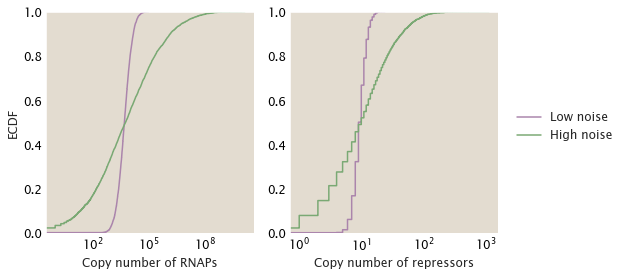

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
ax1, ax2 = axes
sns.ecdfplot(dist_p, ax=ax1, label='Low noise', color='#AB85AC')
sns.ecdfplot(dist_p_high, ax=ax1, label='High noise', color='#7AA974')
ax1.set_xlabel('Copy number of RNAPs')
ax1.set_ylabel('ECDF')
ax1.set_xscale('log')

sns.ecdfplot(dist_r, ax=ax2, label='Low noise', color='#AB85AC')
sns.ecdfplot(dist_r_high, ax=ax2, label='High noise', color='#7AA974')
ax2.set_xlabel('Copy number of repressors')
ax2.set_xscale('log')
ax2.set_ylabel('')
ax2.legend(bbox_to_anchor=(1.6, 0.6), frameon=False)

plt.tight_layout()
plt.savefig('../../manuscript/figures/plots/figS6/extrinsic_noise_SI.pdf')

In [7]:
def get_signal(footprint, region_param):
    signal = np.sum(footprint[(region_param[0]+115):(region_param[1]+116)])
    length = region_param[1] - region_param[0] + 1
    return signal, length

In [27]:
mutant_bank = []
for i in range(20):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

In [28]:
n_NS = len(genome)
n_p = 3000
n_r = 10
ep_wt = -5
er_wt = -15
mean_p = 5000
mean_r = 10

l_alpha = np.arange(0, 0.5, 0.01)
        
l_stn_ratio_rnap10 = []
l_stn_ratio_rnap35 = []
l_stn_ratio_lacI = []
for alpha in l_alpha:
    rnap10 = []
    rnap35 = []
    lacI = []
    for j in range(20):
        df = tregs.simulate.sim_preset_library(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
                                               *[n_NS, rnap_emat, rep_emat, ep_wt, er_wt,
                                                 mean_p, mean_r, alpha],
                                                mutants=mutant_bank[i])
        
        nbins = 2
        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=10**(-6))
        
        region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
        rnap35_signal, rnap35_length = get_signal(footprint, region_params[0])
        rnap10_signal, rnap10_length = get_signal(footprint, region_params[1])
        lacI_signal, lacI_length = get_signal(footprint, region_params[2])

        total_signal = rnap35_signal + rnap10_signal + lacI_signal
        total_noise = np.sum(footprint) - total_signal
        mean_noise = total_noise / (160 - (rnap35_length + rnap10_length + lacI_length))
        
        rnap10.append(rnap10_signal / rnap10_length / mean_noise)
        rnap35.append(rnap35_signal / rnap35_length / mean_noise)
        lacI.append(lacI_signal / lacI_length / mean_noise)
    l_stn_ratio_rnap10.append(np.mean(rnap10))
    l_stn_ratio_rnap35.append(np.mean(rnap35))
    l_stn_ratio_lacI.append(np.mean(lacI))

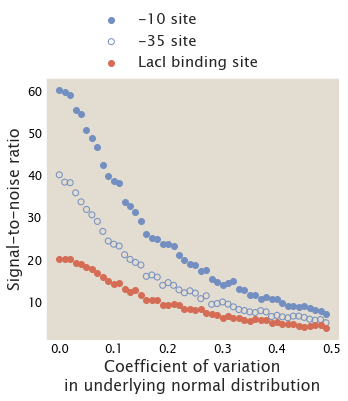

In [48]:
fig, ax = plt.subplots(figsize=(5, 6))
ax.scatter(l_alpha, l_stn_ratio_rnap10, label='-10 site', color='#738FC1')
ax.scatter(l_alpha, l_stn_ratio_rnap35, label='-35 site', facecolors='none', edgecolors='#738FC1', )
ax.scatter(l_alpha, l_stn_ratio_lacI, label='LacI binding site',
           color='#D56C55')
ax.set_xlabel('Coefficient of variation\nin underlying normal distribution', fontsize=16)
ax.set_ylabel('Signal-to-noise ratio',fontsize=16)
ax.legend(bbox_to_anchor=(0.77, 1.3), frameon=False, fontsize=15)

plt.tight_layout()
plt.savefig('../../manuscript/figures/plots/fig15/amplification_bias.pdf')

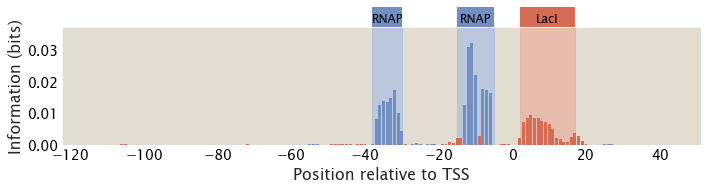

In [34]:
n_NS = len(genome)
ep_wt = -5
er_wt = -15

mean_p = 5000
mean_r = 10
alpha = 0.001

df = tregs.simulate.sim(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
                        *[n_NS, rnap_emat, rep_emat, ep_wt, er_wt,
                          mean_p, mean_r, alpha])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               outfile='../../manuscript/figures/plots/fig15/amplification_bias_fp1.pdf')

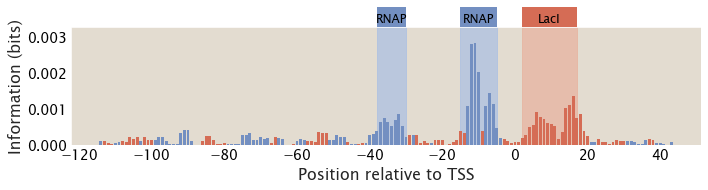

In [35]:
n_NS = len(genome)
ep_wt = -5
er_wt = -15

mean_p = 5000
mean_r = 10
alpha = 0.5

df = tregs.simulate.sim(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
                        *[n_NS, rnap_emat, rep_emat, ep_wt, er_wt,
                          mean_p, mean_r, alpha])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               outfile='../../manuscript/figures/plots/fig15/amplification_bias_fp2.pdf')

### Comparing the magnitude of $\Delta p_{\mathrm{bound}}$ due to change in number of RNAPs/repressors and $\Delta p_{\mathrm{bound}}$ due to random mutations

In [15]:
np.mean(rep_emat) * 4 / 3

2.2410320567814286

In [12]:
np.shape(rep_emat)

(21, 4)

In [9]:
len(genome) / n_p

1547.2173333333333

In [10]:
min_energy_change = 0
max_energy_change = 0
for i in range(rnap_emat.shape[0]):
    min_energy_change += min(rnap_emat[i,:])
    max_energy_change += max(rnap_emat[i,:])

In [11]:
min_energy_changea

-7.503926555517484

In [12]:
max_energy_change

15.051976652082343

In [13]:
np.exp(-min_energy_change-5)

12.230423236482252

In [14]:
np.exp(-max_energy_change-5)

1.9567583184774683e-09

In [6]:
## fixing R, varying P

n_NS = len(genome)
n_r = 10
range_n_p = np.arange(1000, 1000000, 1000)

l_pbound1 = []
for n_p in range_n_p:    
    pbound = tregs.simulate.simrep_pbound(rnap_site, rep_site, rnap_emat, rep_emat, n_p, n_r, n_NS,
                                          ep_wt=-5, er_wt=-15)
    l_pbound1.append(pbound)

In [7]:
## fixing P, varying R

n_NS = len(genome)
n_p = 4600
range_n_r = np.arange(1, 100)

l_pbound2 = []
for n_r in range_n_r:    
    pbound = tregs.simulate.simrep_pbound(rnap_site, rep_site, rnap_emat, rep_emat, n_p, n_r, n_NS,
                                          ep_wt=-5, er_wt=-15)
    l_pbound2.append(pbound)

In [8]:
lac_mutants = np.unique(tregs.wgregseq.mutations_rand(promoter, rate=0.1, num_mutants=10000, number_fixed=True))

rnap_site_start, rnap_site_end = tregs.seq_utils.find_binding_site(promoter, rnap_site)
rep_site_start, rep_site_end = tregs.seq_utils.find_binding_site(promoter, rep_site)

l_mut = []
for mut in lac_mutants:
    rv = {}
    rv['seq'] = mut
    rnap_site_mut = mut[rnap_site_start:rnap_site_end].upper()
    rep_site_mut = mut[rep_site_start:rep_site_end].upper()
    
    n_p = 4600
    n_r = 10
    rv['e_rnap'] = tregs.simulate.get_d_energy(rnap_site_mut, rnap_emat, e_wt=-5)
    rv['e_rep'] = tregs.simulate.get_d_energy(rep_site_mut, rep_emat, e_wt=-15)
    rv['pbound'] = tregs.simulate.simrep_pbound(rnap_site_mut, rep_site_mut, rnap_emat, rep_emat, n_p, n_r, n_NS,
                                                  ep_wt=-5, er_wt=-15)
    l_mut.append(rv)

df_mut = pd.DataFrame.from_records(l_mut)

Note:

For simple repression, the expression for probabiltiy of binding can be written as
$$
\begin{align}
    p_{\mathrm{bound}} &= \frac{\frac{P}{N_{NS}} \cdot e^{- \beta \Delta \varepsilon_{p}}}{1 + \frac{P}{N_{NS}} \cdot e^{- \beta \Delta \varepsilon_{p}} + \frac{R}{N_{NS}} \cdot e^{- \beta \Delta \varepsilon_{r}}} \\
        &= \frac{P \cdot e^{- \beta \Delta \varepsilon_{p}}}{N_{NS} + P \cdot e^{- \beta \Delta \varepsilon_{p}} + R \cdot e^{- \beta \Delta \varepsilon_{r}}}.
\end{align}
$$

Here $P = \mathrm{few} \cdot 10^3$, $e^{-\beta \Delta \varepsilon_p} = e^5 \approx 150$, and $N_{NS} \approx \mathrm{few} \cdot 10^6$. Therefore $P \cdot e^{-\beta \Delta \varepsilon_p} \ll N_{NS}$. This means that we can re-write the probability of binding as
$$
    p_{\mathrm{bound}} = \frac{P \cdot e^{- \beta \Delta \varepsilon_{p}}}{N_{NS} + R \cdot e^{- \beta \Delta \varepsilon_{r}}},
$$
therefore $p_\mathrm{bound}$ is linearly related to $P$.

On the other hand, $R = \mathrm{few} \cdot 10$, $e^{-\beta \Delta \varepsilon_r} = e^{15} \approx \mathrm{few} \cdot 10^6$. Therefore $R \cdot e^{-\beta \Delta \varepsilon_r} \gg N_{NS}$. This means that we can re-write the probability of binding as
$$
    p_{\mathrm{bound}} = \frac{1}{1 + R \cdot e^{- \beta \Delta \varepsilon_{r}}},
$$
therefore $p_\mathrm{bound}$ is linearly related to $R^{-1}$.

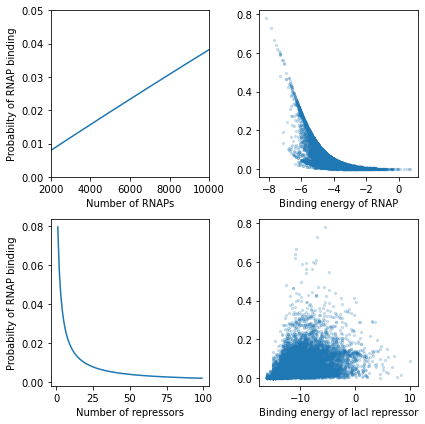

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
ax1, ax2, ax3, ax4 = axes.flatten()

ax1.plot(range_n_p, l_pbound1)
ax1.set_xlim(2000, 10000)
ax1.set_ylim(0, 0.05)
ax1.set_xlabel('Number of RNAPs')
ax1.set_ylabel('Probabilty of RNAP binding')

ax2.scatter(df_mut.e_rnap, df_mut.pbound, alpha=0.2, s=5)
ax2.set_xlabel('Binding energy of RNAP')

ax3.plot(range_n_r, l_pbound2)
ax3.set_xlabel('Number of repressors')
ax3.set_ylabel('Probabilty of RNAP binding')

ax4.scatter(df_mut.e_rep, df_mut.pbound, alpha=0.2, s=5)
ax4.set_xlabel('Binding energy of lacI repressor')

plt.tight_layout()
plt.show()